In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_23986/64509669.py:23: DtypeWarning: Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ga4_data.csv')


In [2]:
# 전처리 
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
df['fullVisitorId'] = df['fullVisitorId'].astype(str)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

df.visitStartTime = (df.visitStartTime - timedelta(hours=8))
# df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
# df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
# df = df.assign(day_name = df.visitStartTime.dt.weekday)

In [7]:
# df.describe(include='all').T

In [8]:

# # RFM -> VFM
# # 방문빈도 : 구매했던 안했던 visitId count
# # 구매건수 : revunue 찍힌 visitId 만 count
# # 총매출 : Total Revenue

# # 방문 빈도 계산 : Visit Count
# # user_visit_Cnt = df.groupby('fullVisitorId')['visitId'].count().to_frame() : 잘못계산함
# user_visit_Cnt = df.groupby('fullVisitorId')['visitId'].nunique().to_frame()

# # 구매건수 계산 : Buy Count
# # user_buy_total_Cnt = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].count().sort_values('totals_totalTransactionRevenue') : 잠시 대기
# # 구매건수 : 구매당 1씩
# user_buy_total_Cnt = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')['visitId'].nunique()


# # 총매출 : 
# user_buy_total_Revenue = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('sum').sort_values('totals_totalTransactionRevenue')

# # 평균매출
# # user_buy_total_Revenue = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('mean').sort_values('totals_totalTransactionRevenue')

In [3]:
구매고객 = df[df['totals_totalTransactionRevenue'] != 0]['fullVisitorId'].unique()
purchase = df[df['fullVisitorId'].isin(구매고객)]

user_visit_Cnt = purchase.groupby('fullVisitorId')['visitId'].nunique().to_frame()
user_buy_total_Cnt = pd.DataFrame(purchase[purchase['totals_totalTransactionRevenue'] != 0].groupby('fullVisitorId')['visitId'].nunique())
user_buy_total_Revenue = purchase[purchase['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('sum')

vvip_VFM = user_visit_Cnt.merge(user_buy_total_Cnt, how='inner', on='fullVisitorId') # V : visit Count
vvip_VFM = vvip_VFM.merge(user_buy_total_Revenue, how='inner', on='fullVisitorId') 

vvip_VFM = vvip_VFM.rename(columns={'visitId_x' : 'visit_Cnt'})
vvip_VFM = vvip_VFM.rename(columns={'visitId_y' : 'buy_Cnt'})
vvip_VFM = vvip_VFM.rename(columns={'totals_totalTransactionRevenue' : 'total_Revenue'})

vvip_VFM

,visit_Cnt,buy_Cnt,total_Revenue
fullVisitorId,,,
0000213131142648941,1,1,39.59
0000435324061339869,3,1,46.79
0000562678147042735,2,1,316.62
0000585708896049892,1,1,45.97
0000852801263780322,1,1,80.00
...,...,...,...
9991633376050115277,1,1,35.59
9994767073213036303,5,1,140.32
9997409246962677759,1,1,40.36


In [4]:
vvip_VFM.to_csv('vfm.csv', index=True)

In [10]:
# df_distinct = df['fullVisitorId'].drop_duplicates()
# df_distinct = pd.DataFrame(df_distinct)

In [11]:
# # 구매한 적이 있는 9463명
# # df 고객 방문 빈도 구하기
# df_V = df_distinct.merge(user_visit_Cnt, how='left', on='fullVisitorId') # V : visit Count
# df_V = df_V.rename(columns={'visitId' : 'visit_Cnt'})

# # df 고객 총 구매 건수 구하기
# df_VF = df_V.merge(user_buy_total_Cnt, how='left', on='fullVisitorId') 
# # df_VF = df_VF.rename(columns={'totals_totalTransactionRevenue' : 'buy_Cnt'})
# df_VF = df_VF.rename(columns={'visitId' : 'buy_Cnt'})

# # df 고객 총매출 구하기
# df_VFM = df_VF.merge(user_buy_total_Revenue, how='left', on='fullVisitorId')
# df_VFM = df_VFM.rename(columns={'totals_totalTransactionRevenue' : 'total_Revenue'})
# df_VFM

In [12]:
# 전체 고객 263466명 version
# # RFM -> VFM
# # 방문빈도 : 구매했던 안했던 visitId count
# # 구매건수 : revunue 찍힌 visitId 만 count
# # 총매출 : Total Revenue

# # 방문 빈도 계산 : Visit Count
# user_visit_Cnt = df.groupby('fullVisitorId')['visitId'].count().to_frame()

# # 구매건수 계산 : Buy Count
# user_buy_total_Cnt = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].count().sort_values('totals_totalTransactionRevenue')

# # 총매출 : 
# user_buy_total_Revenue = df[df['hits_transaction_transactionRevenue'] > 0].groupby('fullVisitorId')[['totals_totalTransactionRevenue']].agg('sum').sort_values('totals_totalTransactionRevenue')

# # vvip 고객 총 구매 건수 구하기
# vvip_VF = user_visit_Cnt.merge(user_buy_total_Cnt, how='left', on='fullVisitorId') 
# vvip_VF = vvip_VF.rename(columns={'visitId' : 'visit_Cnt'})
# vvip_VF = vvip_VF.rename(columns={'totals_totalTransactionRevenue' : 'buy_Cnt'})

# # vvip 고객 총매출 구하기
# vvip_VFM = vvip_VF.merge(user_buy_total_Revenue, how='left', on='fullVisitorId')
# vvip_VFM = vvip_VFM.rename(columns={'totals_totalTransactionRevenue' : 'total_Revenue'})

# #매출이 없고 구매 빈도가 없는 고객을 0으로 치환
# vvip_VFM['buy_Cnt'] = vvip_VFM['buy_Cnt'].fillna(0).astype(int)
# vvip_VFM['total_Revenue'] = vvip_VFM['total_Revenue'].fillna(0).astype(int)

# df_VFM = vvip_VFM

In [13]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(vvip_VFM)

pca_transformed = pd.DataFrame(pca_transformed, columns=(['PCA_x', 'PCA_y']))

pca_transformed.index = vvip_VFM.index

pca_transformed

,PCA_x,PCA_y
fullVisitorId,,
0000213131142648941,-179.143360,-2.387445
0000435324061339869,-171.941351,-0.396480
0000562678147042735,97.887505,-1.667829
0000585708896049892,-172.763363,-2.393882
0000852801263780322,-138.733381,-2.428215
...,...,...
9991633376050115277,-183.143358,-2.383409
9994767073213036303,-78.409386,1.507386
9997409246962677759,-178.373361,-2.388222


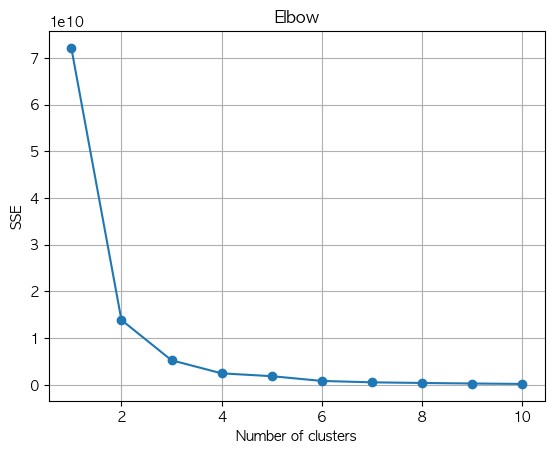

In [14]:
from sklearn.cluster import KMeans

# 최적의 클러스터 확인 : 엘보우 플랏
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(pca_transformed)
    sse.append(km.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid(visible=True)
plt.show()

클러스터 2개 : 실루엣 스코어 0.9986772887597417
클러스터 3개 : 실루엣 스코어 0.9957106401335056
클러스터 4개 : 실루엣 스코어 0.9772871727867156
클러스터 5개 : 실루엣 스코어 0.9772105070580139
클러스터 6개 : 실루엣 스코어 0.9468377296166154
클러스터 7개 : 실루엣 스코어 0.8787912600629301


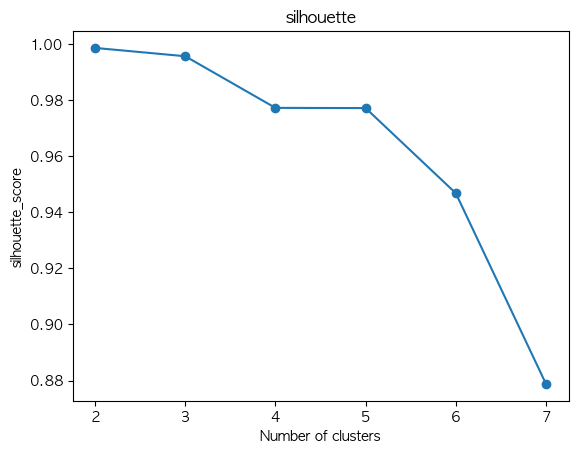

In [15]:
# 최적의 클러스터 확인 : 실루엣 계수
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(pca_transformed)
    score = silhouette_score(pca_transformed, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'클러스터 {k}개 : 실루엣 스코어 {score}')

# 실루엣 분석 그래프 그리기
plt.plot(range(2, 8), silhouette_scores, marker='o')
plt.title('silhouette')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.show()

/Users/dongjekim/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/Users/dongjekim/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


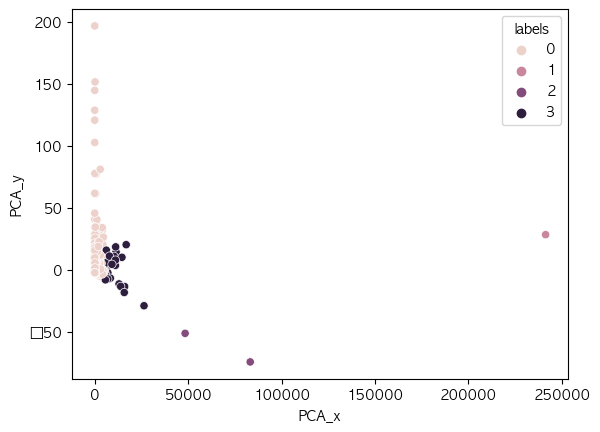

In [16]:
# 클러스터링 함수
from sklearn.cluster import KMeans
import seaborn as sns

def clustering_1(cluster, data):
        # K means clustering 진행
        km = KMeans(n_clusters=cluster, random_state=42)
        km.fit(data)
        # 클러스터 라벨 컬럼 생성
        data['labels'] = km.labels_
        
        # scatter 시각화
        sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue='labels', data=data)
        
clustering_1(4, pca_transformed)

In [17]:
pca_transformed.head(10)

,PCA_x,PCA_y,labels
fullVisitorId,,,
0000213131142648941,-179.143360,-2.387445,0
0000435324061339869,-171.941351,-0.396480,0
0000562678147042735,97.887505,-1.667829,0
0000585708896049892,-172.763363,-2.393882,0
0000852801263780322,-138.733381,-2.428215,0
0001123528056036404,-119.773390,-2.447344,0
0001905118576359487,-196.542345,-1.370776,0
0002527528149176601,-200.743349,-2.365653,0
0002709834583138581,-208.742339,-1.358467,0


In [18]:
vvip_VFM['labels'] = pca_transformed['labels']
vvip_VFM

,visit_Cnt,buy_Cnt,total_Revenue,labels
fullVisitorId,,,,
0000213131142648941,1,1,39.59,0
0000435324061339869,3,1,46.79,0
0000562678147042735,2,1,316.62,0
0000585708896049892,1,1,45.97,0
0000852801263780322,1,1,80.00,0
...,...,...,...,...
9991633376050115277,1,1,35.59,0
9994767073213036303,5,1,140.32,0
9997409246962677759,1,1,40.36,0


In [19]:
vvip_VFM.groupby(['labels']).agg({
        'visit_Cnt': 'mean',
        'buy_Cnt': 'mean',
        'total_Revenue': ['mean', 'count']
}).round(0)

visit_Cnt buy_Cnt total_Revenue      
            mean    mean          mean count
labels                                      
0            4.0     1.0         150.0  9392
1          275.0    16.0      241619.0     1
2            7.0     3.0       65893.0     2
3           13.0     5.0       10543.0    26

In [20]:
final = vvip_VFM[['labels']].reset_index()
final.to_csv('clustering.csv', index=False)

In [21]:
# def sequence(x):
#     if x == 1 or x == 2:
#         return -1
#     elif x == 3:
#         return 1
#     else:
#         return 0

# vvip_VFM['labels'] = vvip_VFM['labels'].apply(sequence)
# # (df_labels[df_labels['labels'] == 1]) = -1
# # (df_labels[df_labels['labels'] == 2]) = -1
# # (df_labels[df_labels['labels'] == 3]) = 1

In [22]:
# vvip_VFM.groupby(['labels']).agg({
#         'visit_Cnt': 'mean',
#         'buy_Cnt': 'mean',
#         'total_Revenue': ['mean', 'count']
# }).round(0)

<Axes: xlabel='Metric', ylabel='Value'>

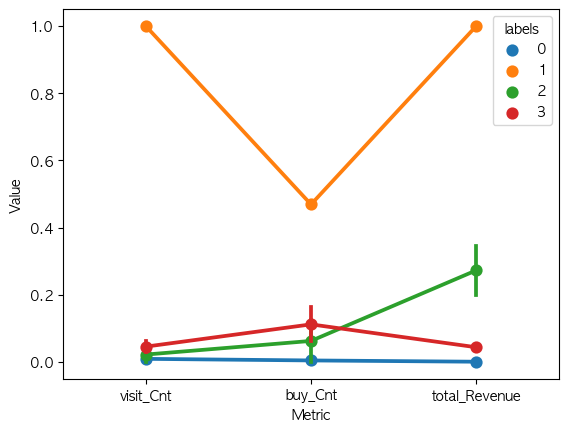

In [23]:
# 스네이크 플롯 시각화 할때만 정규화하기 (잘보이기 위해서)
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.

minmax = minmax_scaler.fit_transform(vvip_VFM)
minmax = pd.DataFrame(minmax, index=vvip_VFM.index, columns=vvip_VFM.columns)
minmax['labels'] = vvip_VFM['labels']

# Melt data into long format
df_melt = pd.melt(minmax.reset_index(), 
                        id_vars=['fullVisitorId', 'labels'],
                        value_vars=['visit_Cnt', 'buy_Cnt', 'total_Revenue'], 
                        var_name='Metric', 
                        value_name='Value')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Metric', y='Value', hue='labels')

Text(0.5, 1.0, '0번 구매 건수')

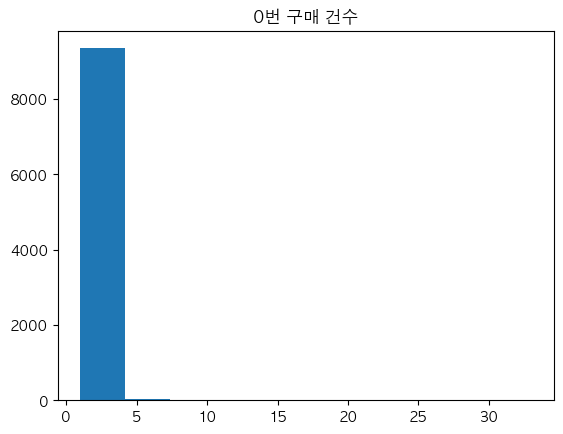

In [40]:
zero = vvip_VFM[vvip_VFM['labels'] == 0]
plt.hist(zero['buy_Cnt'])
plt.title(f"0번 구매 건수")

In [32]:
zero['buy_Cnt'].value_counts()

buy_Cnt
1     8499
2      673
3      140
4       40
5       14
6       12
7        6
8        3
13       1
14       1
33       1
10       1
9        1
Name: count, dtype: int64

In [51]:
zero['buy_Cnt'].mean()

1.1405451448040886

In [49]:
num1 = int(zero[zero['buy_Cnt'] == 1].shape[0])
num2 = int(zero['buy_Cnt'].shape[0])
num1 / num2

0.9049190800681431

In [50]:
zero['visit_Cnt'].mean()

3.5070272572402046

In [ ]:
#df.style.bar()